<center><img src="https://www.mindinventory.com/blog/wp-content/uploads/2019/04/python-development-1200x500.png" width="1000"></center>

# Programa de Especialización en Python

## Tema 7: Regresión Logística

### Caso: Reclamos de servicios de red

### Prof. Manuel Sigüeñas, M.Sc.(c)
[msiguenas@socialdata-peru.com](msiguenas@socialdata-peru.com)

1. [Importar y preprocesar la data](#part1) 
2. [Construir la data de en entrenamiento y de prueba (test)](#part2)
3. [Balanceo de datos](#part3)
4. [Regresión Logística-entrenamiento](#part4) 

In [2]:
from IPython.display import Image
%matplotlib inline


____
[Ir a inicio](#beginning)

El objetivo es construir un modelo para predecir si en cierta zona habrá o no habrá reclamo de clientes (indicentes). Para ello cada registro contiene información de:

**RSRP:** Nivel de Señal medido en dBm. Generalmente una buena señal es de -70 dBm, y luego se va degradando hacia valores muy malos por debajo de -115 dBm. Mientras más negativo es el valor peor es la señal. Con respecto a este valor, es importante señalar que los **valores perdidos** fueron codificados como **0**.

**Redireccion:** Si una red 4G hay redirecciones o transiciones hacia 3G es un indicativo de que hay problemas en la señal. Esta variable indica la cantidad de conexiones que se van a 3G.

**CQI:** Indicador de la calidad del enlace de radiofrecuencia. Los valores van de 1 a 15. 6 o 7 son valores malos, a partir de 12 hay una buena calidad. A menor calidad hay propensión de mayor reclamos.

**Incidentes:** Variable objetivo, que indica la cantidad de reclamos que existen en la zona. Podemos recodificar 1: Reclamo, 0: No Reclamo. Hay valores 0, nulos, vacíos que habría que limpiar. Adicionalmente hay pocos indicentes (Reclamos) con relación a la cantidad de registros, por lo que habría que como tarea previa (preprocesamiento) realizar un **balanceo de datos**.

- **Paquetes necesarios**:

In [4]:
#pip install tensorflow

In [5]:
# imbalanced-learn requiere los siguientes paquetes:
import numpy as np
import scipy
import simport statsmodels.api as smklearn
import tensorflow #(opcional)
import keras #requiere instalar tensorflow (opcional)

In [6]:
#!pip install imbalanced-learn

In [7]:
#pip install --user git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from pylab import rcParams

In [10]:
#Después de la instalación exitosa, la extensión watermark se puede cargar a través de:
%reload_ext watermark
%watermark -a "Social Data Consulting" -u -d -p numpy,scipy,matplotlib,sklearn

Social Data Consulting 
last updated: 2019-10-19 

numpy 1.16.2
scipy 1.2.1
matplotlib 3.0.3
sklearn 0.21.3


In [11]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
#from imblearn.ensemble import BalancedBaggingClassifier

In [12]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [13]:
import statsmodels.api as sm

____
[Ir a inicio](#beginning)

<a id='part1'></a>
## Importar y preprocesar la data

In [14]:
os.getcwd() #esto te permite conocer el directorio actual

'C:\\Users\\SOCIAL DATA'

In [16]:
os.chdir("D:/Python/2. Nivel II/7/datos") # la ruta absoluta
#una vez ubicado en el directorio adecuado puedes ejecutar el comando 

In [18]:
FileCSV="Grid v1.csv"
entel=pd.read_csv(FileCSV)
entel.head(n=5)

,Description,Col_Name,Row_Name,rsrp,incidentes,redireccion,best_server,cqi
0,A1,A,1,0.0,0,0.0,NaN,0.0
1,A2,A,2,0.0,0,0.0,NaN,0.0
2,A3,A,3,0.0,0,0.0,NaN,0.0
3,A4,A,4,0.0,0,0.0,NaN,0.0
4,A5,A,5,0.0,0,0.0,NaN,0.0


In [19]:
print(entel.shape)

(197640, 8)


In [20]:
entel = entel.loc[(entel['rsrp'] < 0)]
print(entel.shape)

(23103, 8)


In [21]:
print(pd.value_counts(entel['incidentes'], sort = True))

0    21601
1     1279
2      167
3       41
4       11
6        2
7        1
5        1
Name: incidentes, dtype: int64


In [22]:
entel.dtypes

Description     object
Col_Name        object
Row_Name         int64
rsrp           float64
incidentes       int64
redireccion    float64
best_server     object
cqi            float64
dtype: object

In [23]:
#código para cambiar formato de datos
#entel['incidentes'] = entel['incidentes'].astype(np.float64) 

In [24]:
entel['incidentes']=entel["incidentes"].replace([2, 3, 4, 5, 6, 7],1)

In [25]:
print(pd.value_counts(entel['incidentes'], sort = True))

0    21601
1     1502
Name: incidentes, dtype: int64


In [26]:
entel = entel[["rsrp", "redireccion", "cqi", "incidentes"]]

In [27]:
entel.head()

,rsrp,redireccion,cqi,incidentes
14400,-115.7500,884.696988,10.856694,0
14949,-112.7500,381.359613,11.205094,0
15498,-118.3750,713.387431,8.729160,0
16046,-115.3750,307.311721,9.607077,0
16596,-118.1875,1728.576707,9.835512,0


<a id='part2'></a>
## Construir data de entrenamiento y de prueba (test)  

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X, y = entel.iloc[:, 0:3].values, entel.iloc[:, 3].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [30]:
#Datos de entrenamiento
x_t= pd.DataFrame(X_train, columns=["rsrp", "redireccion", "cqi"])
y_t= pd.DataFrame(y_train, columns=["incidentes"])

entel_entrenamiento = pd.concat([x_t, y_t], axis=1)
entel_entrenamiento.head()

,rsrp,redireccion,cqi,incidentes
0,-118.7500,11229.222100,7.420288,0
1,-109.3750,4810.049775,8.735570,0
2,-118.5625,14817.830880,7.855299,0
3,-111.4375,374.690909,8.024744,0
4,-105.0625,771.971040,11.067591,0


Text(0, 0.5, 'número de observaciones')

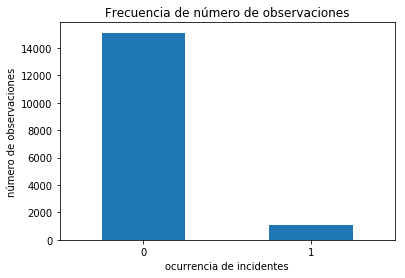

In [31]:
count_classes = pd.value_counts(entel_entrenamiento['incidentes'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones")
plt.xlabel("ocurrencia de incidentes")
plt.ylabel("número de observaciones")

<a id='part3'></a>
## Balanceo de datos   

##### Resampling con Smote-Tomek

técnica muy usada que consiste en aplicar en simultáneo un algoritmo de **UnderSampling** y otro de **OverSampling** a la vez al dataset. Se utilizará **SMOTE** **(Syntetic Minority Oversamplig
Technique)** para oversampling: busca puntos vecinos cercanos y agrega puntos «en linea recta» entre ellos. Y usaremos **Tomek** para undersampling que quita los de distinta clase que sean vecinos más cercanos y deja ver mejor la decisión boundary (la zona limítrofe de nuestras clases).

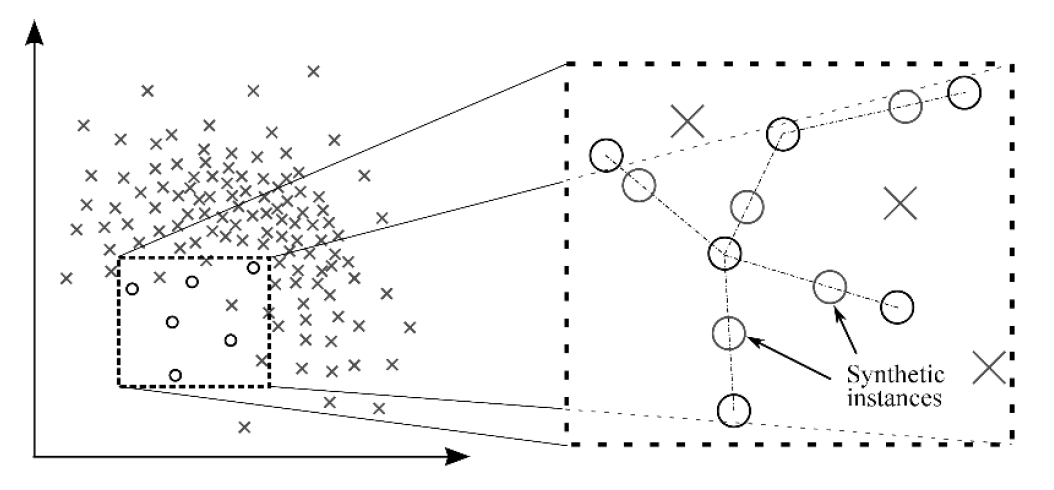

In [32]:
Image(filename='D:/Python/2. Nivel II/7/imagenes/rs.png', width=600) 

In [34]:
os_us = SMOTETomek(ratio=0.5)

##### valores balanceados

In [35]:
X_t_st, y_t_st = os_us.fit_sample(X_train, y_train)

In [83]:
X_p_st, y_p_st = os_us.fit_sample(X_test, y_test)

##### Datos de entrenamiento

In [37]:
#Datos de entrenamiento
x_t_st= pd.DataFrame(X_t_st, columns=["rsrp", "redireccion", "cqi"])
y_t_st= pd.DataFrame(y_t_st, columns=["incidentes"])

entel_entrenamiento_smotetomek = pd.concat([x_t_st, y_t_st], axis=1)
entel_entrenamiento_smotetomek.head()

,rsrp,redireccion,cqi,incidentes
0,-109.3750,4810.049775,8.735570,0
1,-118.5625,14817.830880,7.855299,0
2,-111.4375,374.690909,8.024744,0
3,-105.0625,771.971040,11.067591,0
4,-118.3750,15652.695430,9.778203,0


Text(0, 0.5, 'número de observaciones')

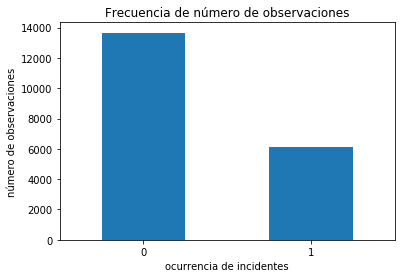

In [38]:
count_classes = pd.value_counts(entel_entrenamiento_smotetomek['incidentes'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones")
plt.xlabel("ocurrencia de incidentes")
plt.ylabel("número de observaciones")

In [40]:
print(pd.value_counts(entel_entrenamiento_smotetomek['incidentes'], sort = True))

0    13658
1     6097
Name: incidentes, dtype: int64


In [41]:
print(entel_entrenamiento_smotetomek.shape)

(19755, 4)


<a id='part4'></a>
## Regresión Logística - Entrenamiento


In [42]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [43]:
logit = LogisticRegression()

##### identificación de variables en el modelo

In [45]:
entel_vars

['rsrp', 'redireccion', 'cqi', 'incidentes']

In [44]:
entel_vars = entel.columns.values.tolist()
Y = ['incidentes']
X = [v for v in entel_vars if v not in Y]

##### recursive feature elimination (RFE) 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [46]:
n = 2

In [49]:
selec = RFE(logit, n)
selec = selec.fit(entel[X], entel[Y].values.ravel())

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
print(selec.support_)

[ True False  True]


In [51]:
print(selec.ranking_)

[1 2 1]


In [52]:
z=zip(entel_vars,selec.support_, selec.ranking_)

In [53]:
list(z)

[('rsrp', True, 1), ('redireccion', False, 2), ('cqi', True, 1)]

### Estimación con statsmodel

#### Estimacion del modelo con datos sin balancear

In [69]:
import statsmodels.api as sm

In [65]:
x_entel = entel[["rsrp", "redireccion", "cqi"]]
y_entel = entel["incidentes"]

In [66]:
logit = sm.Logit(y_entel, x_entel)

In [67]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.236288
         Iterations 7


In [68]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.018     
Dependent Variable: incidentes       AIC:              10923.9341
Date:               2019-10-19 07:55 BIC:              10948.0773
No. Observations:   23103            Log-Likelihood:   -5459.0   
Df Model:           2                LL-Null:          -5557.3   
Df Residuals:       23100            LLR p-value:      1.9804e-43
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
rsrp            0.0250    0.0013  19.0115  0.0000   0.0224  0.0276
redireccion     0.0000    0.0000  16.5292  0.0000   0.0000  0.0000
cqi            -0.0008    0.0181  -0.0469  0.9626  -0.0363  0.0346
=================================================================

"""

#### Estimacion del modelo con datos balanceados

In [ ]:
import statsmodels.api as sm

In [70]:
x_entel = entel_entrenamiento_smotetomek[["rsrp", "redireccion", "cqi"]]
y_entel = entel_entrenamiento_smotetomek["incidentes"]

In [71]:
logit = sm.Logit(y_entel, x_entel)

In [72]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.586813
         Iterations 5


In [73]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.050      
Dependent Variable: incidentes       AIC:              23190.9757 
Date:               2019-10-19 08:00 BIC:              23214.6492 
No. Observations:   19755            Log-Likelihood:   -11592.    
Df Model:           2                LL-Null:          -12209.    
Df Residuals:       19752            LLR p-value:      2.6563e-268
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-------------------------------------------------------------------
rsrp             0.0109    0.0008  13.2691  0.0000   0.0093  0.0125
redireccion      0.0000    0.0000  31.3897  0.0000   0.0000  0.0000
cqi              0.0040    0.0114   0.3477  0.7281  -0.0184  0.0263
==================================================================

"""

### Estimación con  scikit-learn

In [78]:
from sklearn import linear_model

In [79]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X_t_st,y_t_st)

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Validación del modelo logístico

##### accuracy 

In [80]:
#entrenamiento 
logit_model.score(X_t_st,y_t_st)

0.7047835990888383

In [87]:
#prueba / test
logit_model.score(X_p_st,y_p_st)

0.7156791026578884

##### Probabilidad predicha por el modelo para los datos de prueba

In [85]:
probs = logit_model.predict_proba(X_p_st)

In [86]:
probs

array([[0.72667032, 0.27332968],
       [0.66111191, 0.33888809],
       [0.72993522, 0.27006478],
       ...,
       [0.62624344, 0.37375656],
       [0.51087941, 0.48912059],
       [0.76094055, 0.23905945]])

In [88]:
prediction = logit_model.predict(X_p_st)

In [89]:
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.5
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
prob_df.head()

,0,prediction
0,0.273330,0
1,0.338888,0
2,0.270065,0
3,0.271585,0
4,0.228220,0


In [91]:
from sklearn import metrics

In [92]:
metrics.accuracy_score(y_p_st, prediction)

0.7156791026578884

##### Validación cruzada

In [95]:
from sklearn.model_selection import cross_val_score

In [97]:
scores = cross_val_score(linear_model.LogisticRegression(), X_t_st, y_t_st, scoring="accuracy", cv=10)

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

In [98]:
scores

array([0.70293522, 0.70445344, 0.7034413 , 0.71204453, 0.69686235,
       0.69989879, 0.71052632, 0.70582278, 0.70719352, 0.70871327])

In [99]:
scores.mean()

0.7051891516377179

##### Matrices de Confusión

In [103]:
confusion_matrix = pd.crosstab(prob_df.prediction, y_p_st)
confusion_matrix

col_0,0,1
prediction,,
0,5493,2104
1,228,377


In [106]:
VN=confusion_matrix[0][0]
VP=confusion_matrix[1][1]
FN=confusion_matrix[0][1]
FP=confusion_matrix[1][0]

In [107]:
sens = VP/(VP+FN)
sens

0.6231404958677685

In [108]:
espc_1 = 1-VN/(VN+FP)
espc_1

0.27695142819534024

##### Curvas ROC

In [113]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Curva ROC')

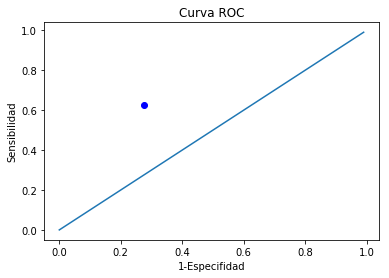

In [115]:
%matplotlib inline
plt.plot(espc_1, sens, marker="o", linestyle="--", color="b")
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")


____
[Ir a inicio](#beginning)